# Loan Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")



#### Data Loading

In [2]:
loan_df = pd.read_csv(r"C:\Users\polin\Desktop\Python\Projects\Project@1\loan.csv")
region_df = pd.read_csv(r"C:\Users\polin\Desktop\Python\Projects\Project@1\loan_with_region.csv")
purpose_df = pd.read_csv(r"C:\Users\polin\Desktop\Python\Projects\Project@1\loan_purposes.csv")
year_df = pd.read_csv(r"C:\Users\polin\Desktop\Python\Projects\Project@1\loan_count_by_year.csv")
customer_df = pd.read_csv(r"C:\Users\polin\Desktop\Python\Projects\Project@1\customer.csv")
state_df = pd.read_csv(r"C:\Users\polin\Desktop\Python\Projects\Project@1\state_region.csv")

#### Merging the DataFrames 

In [3]:
df_merged = pd.merge(loan_df,customer_df,on="customer_id")
df = pd.merge(df_merged,state_df,left_on='addr_state',right_on='state')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270299 entries, 0 to 270298
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_id              270299 non-null  int64  
 1   customer_id          270299 non-null  object 
 2   loan_status          270299 non-null  object 
 3   loan_amount          270299 non-null  float64
 4   state_x              270299 non-null  object 
 5   funded_amount        270299 non-null  float64
 6   term                 270299 non-null  object 
 7   int_rate             270299 non-null  float64
 8   installment          270299 non-null  float64
 9   grade                270299 non-null  object 
 10  issue_d              270299 non-null  object 
 11  issue_date           270299 non-null  object 
 12  issue_year           270299 non-null  float64
 13  pymnt_plan           270299 non-null  bool   
 14  type                 270299 non-null  object 
 15  purpose          

#### Data Cleaning 

In [4]:
missing_vals =df.isna().sum()
print(missing_vals[missing_vals>0])

description           2343
emp_title            23662
emp_length           18745
annual_inc_joint    251505
dtype: int64


When a column has a high proportion of missing or NaN values, it’s best to drop it, since including it may bias the machine learning model due to the lack of sufficient valid data

In [5]:
df_clean =df.copy()
df_clean = df_clean.drop('annual_inc_joint',axis=1)
print("Annual joint account column Dropped")

df_clean = df_clean.drop('emp_title',axis=1)
print("emp title column Dropped")

df_clean['emp_length'].fillna('uknown',inplace=True)
df_clean['description'].fillna('Uknown',inplace=True)

Annual joint account column Dropped
emp title column Dropped


In [6]:
missing_vals =df_clean.isna().sum()
print(missing_vals)

loan_id                0
customer_id            0
loan_status            0
loan_amount            0
state_x                0
funded_amount          0
term                   0
int_rate               0
installment            0
grade                  0
issue_d                0
issue_date             0
issue_year             0
pymnt_plan             0
type                   0
purpose                0
description            0
notes                  0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
zip_code               0
addr_state             0
avg_cur_bal            0
Tot_cur_bal            0
state_y                0
subregion              0
region                 0
dtype: int64


## After cleaning the dataset and removing all null values, we’re ready to move on to the Exploratory Data Analysis (EDA) phase.

In [7]:
print("--- Loan Status Counts ---")
print(df_clean['loan_status'].value_counts())

df_analysis = df_clean[df_clean['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()


df_analysis['defaulted'] = df_analysis['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)


print("\n\n--- Analysis DataFrame Head ---")
print(df_analysis[['loan_id', 'loan_status', 'defaulted']].head())

default_rate = df_analysis['defaulted'].mean()
print(f"\n\nOverall Default Rate: {default_rate * 100:.2f}%")

--- Loan Status Counts ---
loan_status
Current               170461
Fully Paid             76361
Charged Off            17851
Late (31-120 days)      3174
In Grace Period         1638
Late (16-30 days)        802
Default                   12
Name: count, dtype: int64


--- Analysis DataFrame Head ---
   loan_id  loan_status  defaulted
0     1079   Fully Paid          0
1     1613   Fully Paid          0
2     1865   Fully Paid          0
4     5259   Fully Paid          0
5     5943  Charged Off          1


Overall Default Rate: 18.95%


### Exploring the Distribution of Key Numerical Variables

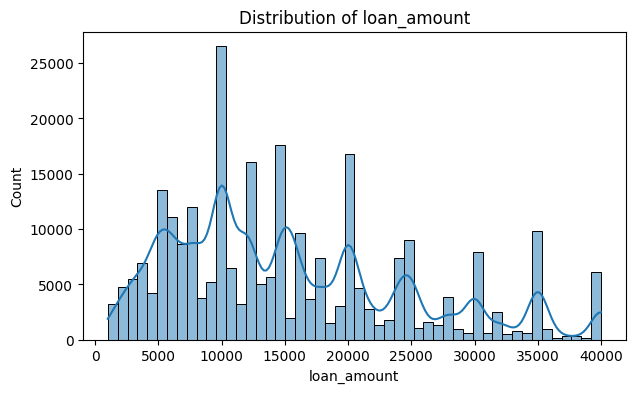

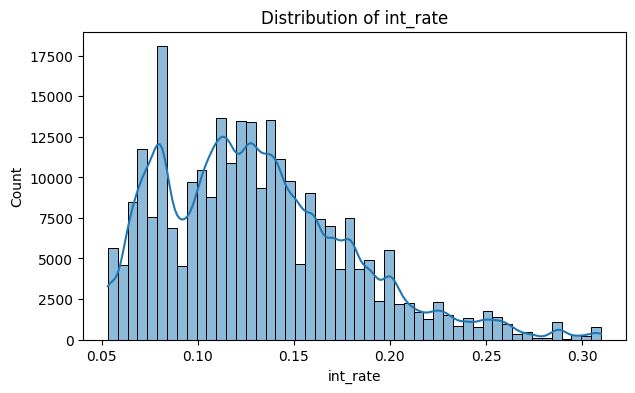

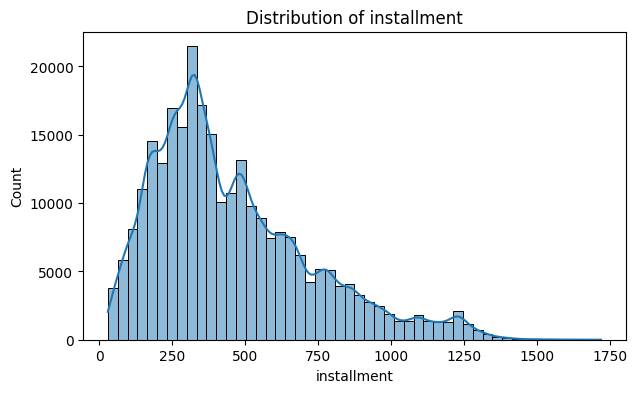

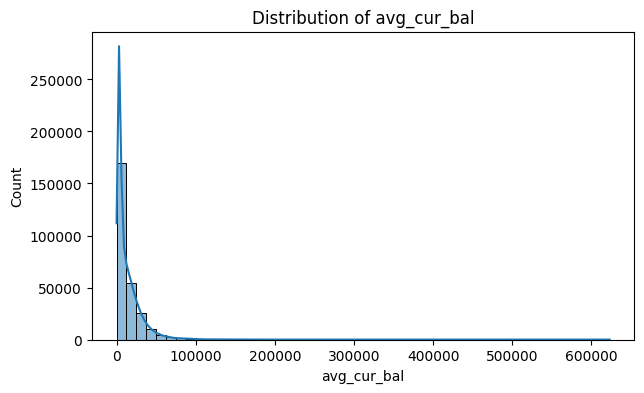

In [8]:
num_cols = ['loan_amount', 'int_rate', 'installment', 'avg_cur_bal'] 

for col in num_cols:
    if col not in df.columns:
        print(f"Skipping missing column: {col}")
        continue
    plt.figure(figsize=(7,4))  
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


These histograms display the distribution of key numerical features in the dataset.

loan_amount: Shows noticeable spikes at rounded values (e.g., $10k, $20k), indicating common borrowing amounts.

annual_inc: Is heavily right-skewed — most borrowers have low to moderate incomes, with a few high-income outliers.

int_rate: Displays multiple peaks, likely corresponding to different loan grades or risk tiers.

avg_cur_bal: The distribution is highly skewed with several extreme outliers, suggesting a few borrowers maintain unusually high average current balances compared to the majority.

In [9]:
df_clean['issue_date'] = pd.to_datetime(df_clean['issue_date'])

df_clean['issue_year'] = df_clean['issue_date'].dt.year
df_clean['issue_month'] = df_clean['issue_date'].dt.month

df_analysis = df_clean[df_clean['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()
df_analysis['defaulted'] = df_analysis['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

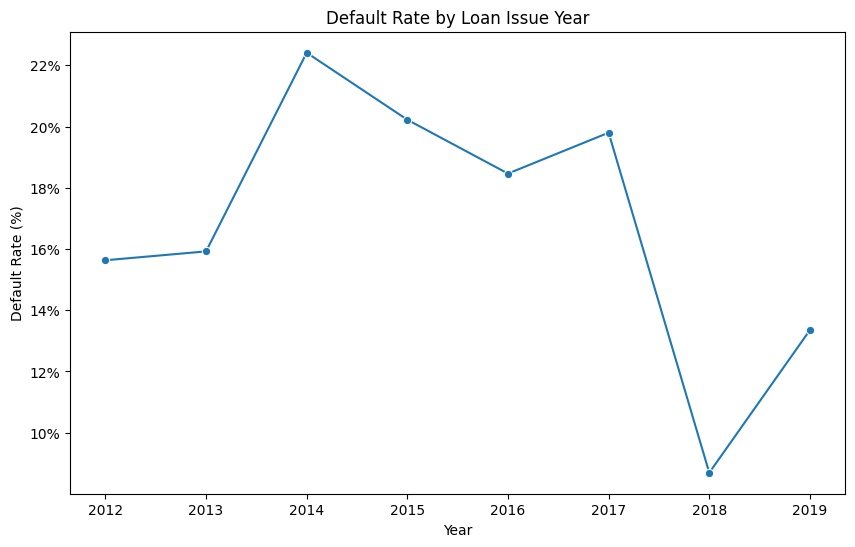

In [10]:
default_rate_by_year = df_analysis.groupby('issue_year')['defaulted'].mean() * 100

plt.figure(figsize=(10, 6))
sns.lineplot(x=default_rate_by_year.index, y=default_rate_by_year.values, marker='o')
plt.title('Default Rate by Loan Issue Year')
plt.xlabel('Year')
plt.ylabel('Default Rate (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, p: f'{y:.0f}%'))
plt.show()

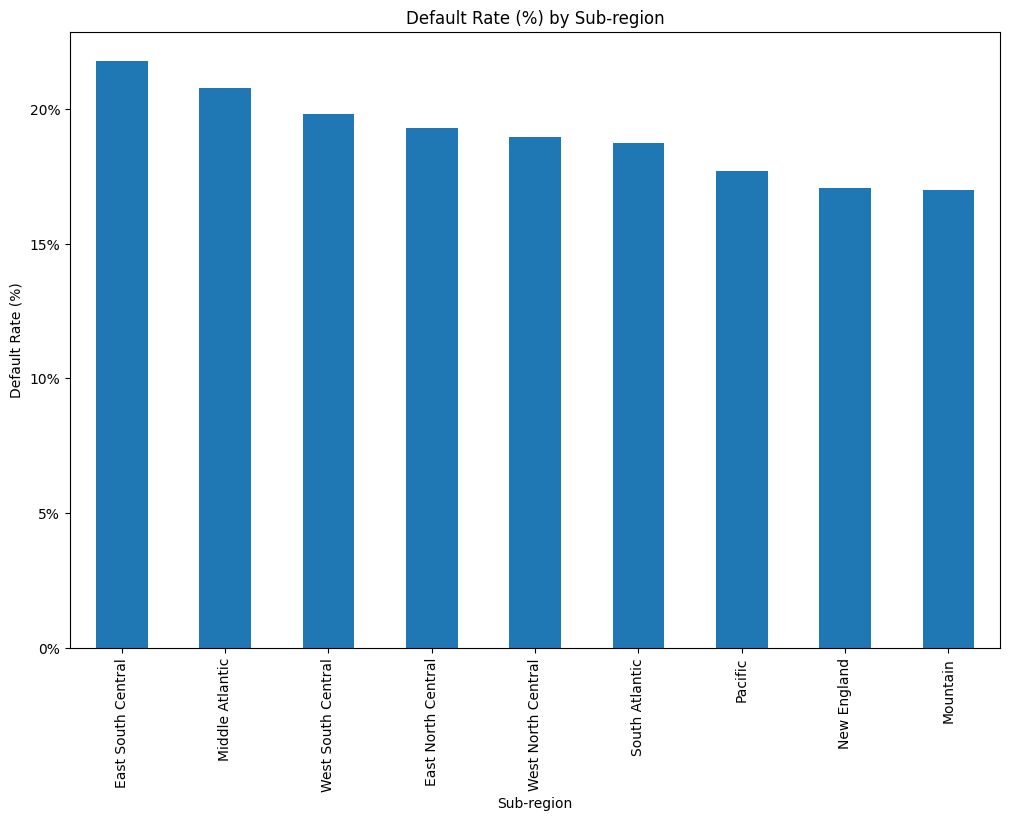

In [11]:
region_default_ct = pd.crosstab(df_analysis['subregion'], df_analysis['defaulted'])

region_default_rate = region_default_ct.div(region_default_ct.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
region_default_rate[1].sort_values(ascending=False).plot(kind='bar')
plt.title('Default Rate (%) by Sub-region')
plt.xlabel('Sub-region')
plt.ylabel('Default Rate (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, p: f'{y*100:.0f}%'))
plt.show()

### Let’s check whether the loan grade impacts the default rate.

In [12]:
grade_default_rate = df_analysis.groupby('grade')['defaulted'].mean().sort_values() * 100
print(grade_default_rate.reset_index(name="default rate %"))

  grade  default rate %
0     A        5.800840
1     B       12.269026
2     C       20.932420
3     D       28.470880
4     E       38.100240
5     F       46.122995
6     G       47.982063


### Visualize the results using Barplot

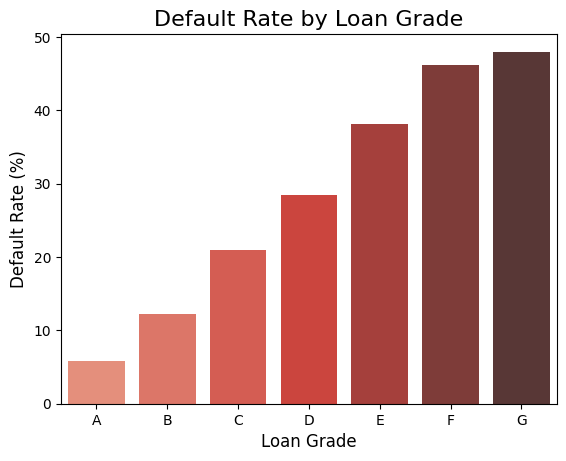

In [13]:
plt.Figure(figsize=(10,6))

sns.barplot(
    x =grade_default_rate.index,
    y = grade_default_rate.values,
    palette="Reds_d"
)
plt.title("Default Rate by Loan Grade", fontsize=16),
plt.xlabel("Loan Grade",fontsize=12),
plt.ylabel("Default Rate (%)",fontsize=12)

plt.show()

The bar chart reveals a distinct "staircase" pattern: as loan grades deteriorate from A to G, the default rate rises steadily. Grade ‘A’ loans show minimal risk (5.8% default), whereas grades ‘F’ and ‘G’ demonstrate significantly higher risk, exceeding 46% defaults.

### Let’s see whether the loan purpose has any effect on the default rate

In [14]:
purpose_default_rate = df_analysis.groupby('purpose')['defaulted'].mean().sort_values(ascending=False) * 100
print(purpose_default_rate.reset_index(name="default rate %"))


               purpose  default rate %
0       small_business       27.185501
1               moving       21.542940
2   debt_consolidation       20.252683
3              medical       19.654842
4                other       19.332813
5       major_purchase       17.969165
6     renewable_energy       17.460317
7             vacation       17.440000
8     home_improvement       17.218655
9                house       16.468254
10         credit_card       15.947016
11                 car       13.111342
12             wedding       11.904762


### Visualize the results using Horiznatal BarPlot

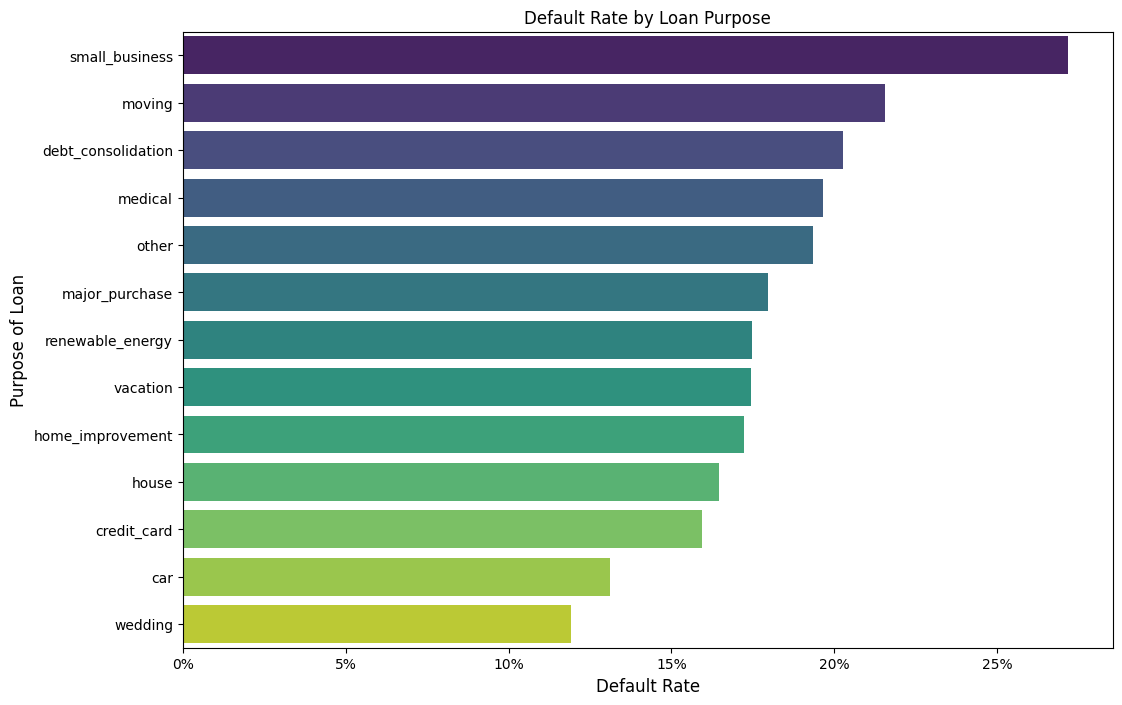

In [15]:

plt.figure(figsize=(12,8))

barplot = sns.barplot(
    x =purpose_default_rate.values,
    y = purpose_default_rate.index,
    palette="viridis"

)
plt.xlabel("Default Rate", fontsize = 12)
plt.ylabel("Purpose of Loan",fontsize = 12)
plt.title("Default Rate by Loan Purpose")

barplot.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.0f}%'))
plt.show()

Indeed, ‘Small Business’ loans stand out as the most risky, defaulting at over 27% — much higher than categories like ‘Moving’ and ‘Debt Consolidation’. On the other hand, ‘Wedding’ and ‘Car’ loans are among the safest, with the lowest default rates.

### Let’s see whether the loan term has any impact on the default rate

In [16]:
print("\n--- Default Rate by Loan Term ---")
term_defaulted = df_analysis.groupby('term')['defaulted'].mean().sort_values(ascending=False)
print(term_defaulted* 100)


--- Default Rate by Loan Term ---
term
60 months    31.420113
36 months    15.004191
Name: defaulted, dtype: float64


### Visualization using 

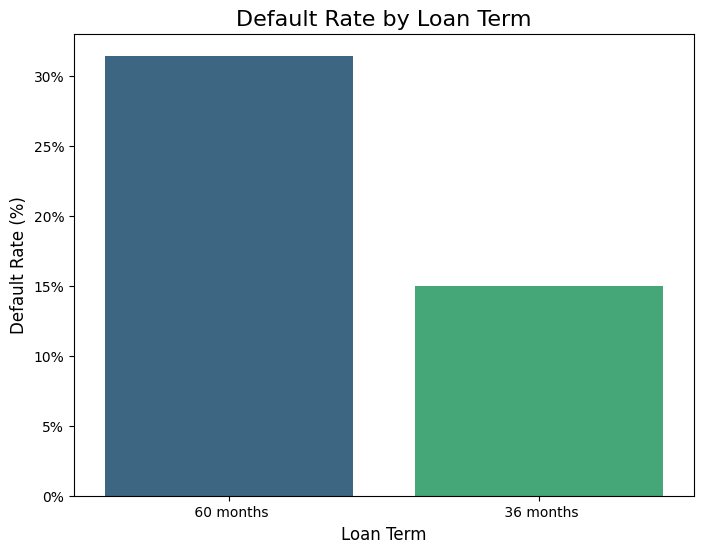

In [17]:
plt.figure(figsize=(8, 6))

barplot = sns.barplot(
    x=term_defaulted.index,
    y=term_defaulted.values * 100,
    palette="viridis"
)

plt.title('Default Rate by Loan Term', fontsize=16)
plt.xlabel('Loan Term', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)

barplot.yaxis.set_major_formatter(FuncFormatter(lambda y, p: f'{y:.0f}%'))

plt.savefig("default_rate_by_term.png")
plt.show()

The analysis shows that longer loan terms are associated with higher risk. Specifically, 60-month loans have a default rate of 31.4%, which is more than double the 15.0% rate observed for 36-month loans.

### Let’s analyze the distribution of loan statuses across various sub-regions.

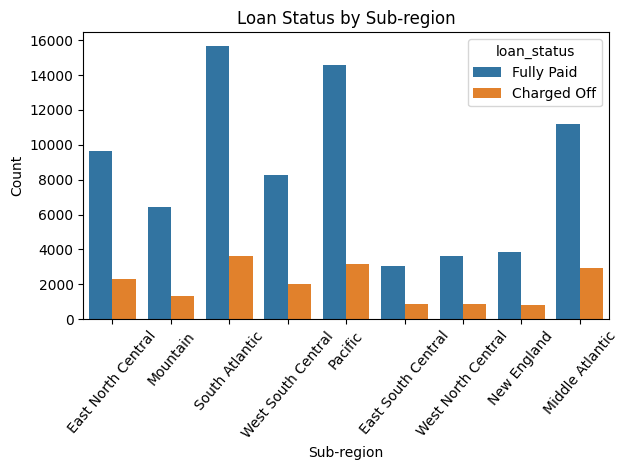

In [18]:
plt.Figure(figsize=(12,8))

sns.countplot(
    data = df_analysis,
    x = 'subregion',
    hue='loan_status',
    )
plt.title('Loan Status by Sub-region')
plt.xlabel('Sub-region')
plt.ylabel('Count')
plt.xticks(rotation=50)  
plt.tight_layout() 
plt.show()

The chart illustrates how loan statuses are distributed among different sub-regions. It provides insights into regions that may have a disproportionately high number of ‘Charged Off’ or ‘Late’ loans compared to their overall loan activity

### Let’s analyze the overall verification status counts and their distribution across regions

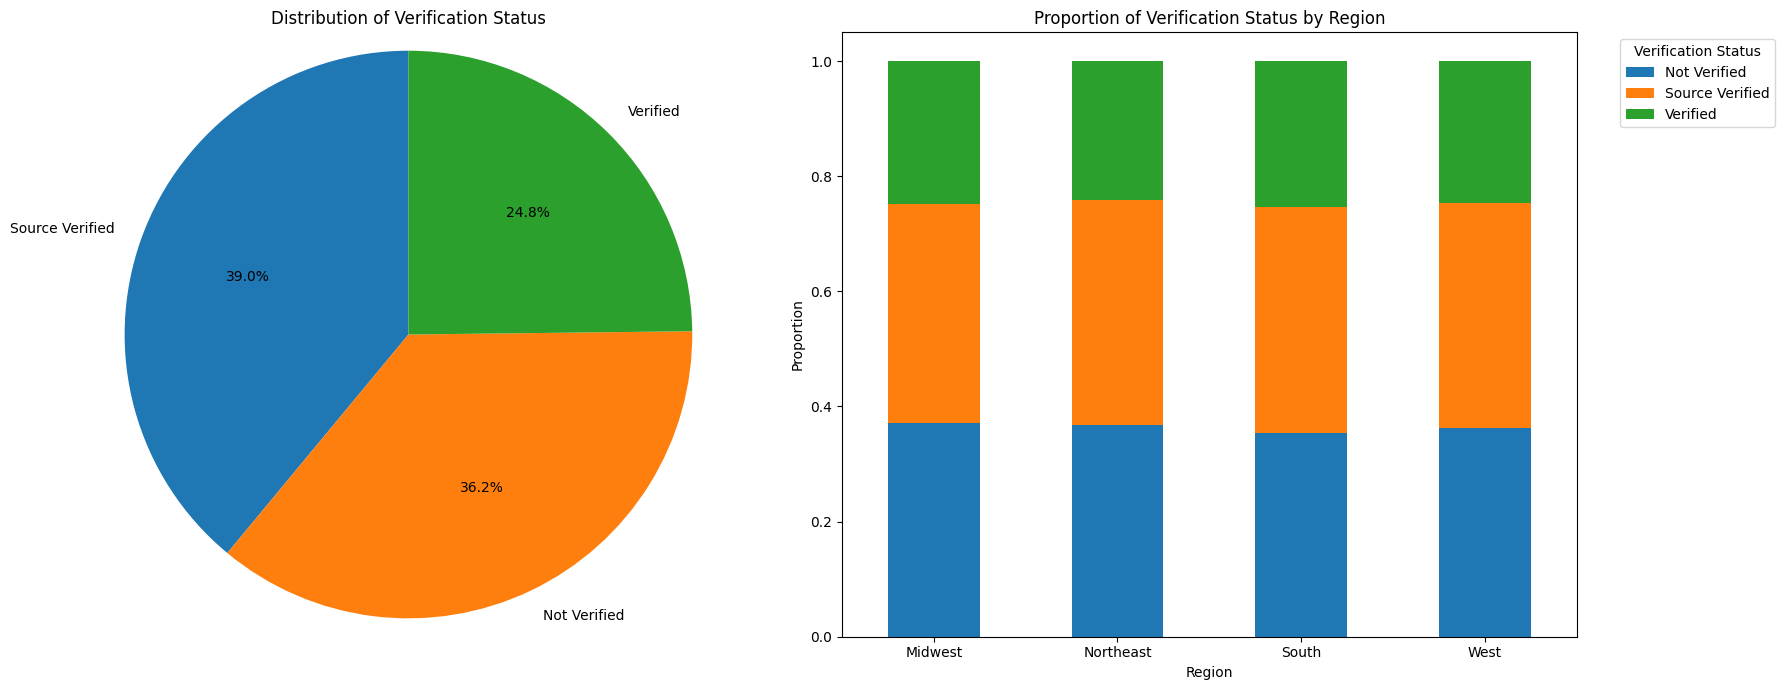

In [19]:
ct = pd.crosstab(df['region'], df['verification_status'])
data_for_plot = ct.div(ct.sum(axis=1), axis=0)

vc = df['verification_status'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

data_for_plot.plot(
    kind='bar',
    stacked=True,
    rot=0,
    ax=axes[1]
)
axes[1].set_title('Proportion of Verification Status by Region')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Verification Status', bbox_to_anchor=(1.05, 1), loc='upper left')

axes[0].pie(
    vc,
    labels=vc.index,
    autopct='%1.1f%%',
    startangle=90
)
axes[0].set_title('Distribution of Verification Status')
axes[0].axis('equal')

fig.tight_layout()
plt.show()

### Let’s check how home ownership varies across different regions.


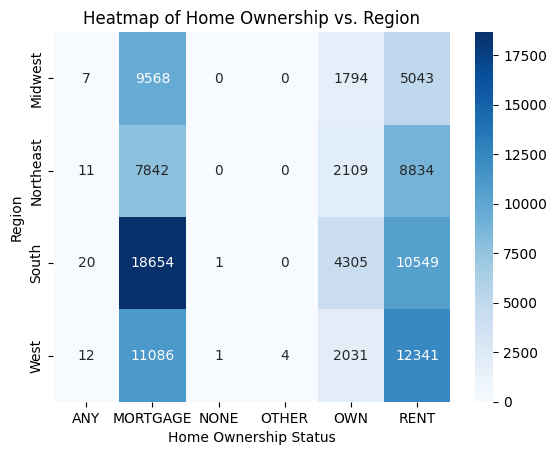

In [20]:
ct = df_analysis.groupby(['region','home_ownership']).size().unstack(fill_value=0)
sns.heatmap(
    ct,
    annot = True,  
    fmt='d',      
    cmap='Blues'
)
plt.title('Heatmap of Home Ownership vs. Region')
plt.xlabel('Home Ownership Status')
plt.ylabel('Region')

plt.show()

The heatmap illustrates loan counts across different region and home ownership combinations. In most regions, ‘Mortgage’ and ‘Rent’ dominate, whereas ‘Own’ is relatively uncommon. This visualization helps in profiling the typical borrower characteristics by region.

In [21]:
df_analysis.columns

Index(['loan_id', 'customer_id', 'loan_status', 'loan_amount', 'state_x',
       'funded_amount', 'term', 'int_rate', 'installment', 'grade', 'issue_d',
       'issue_date', 'issue_year', 'pymnt_plan', 'type', 'purpose',
       'description', 'notes', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'zip_code', 'addr_state', 'avg_cur_bal',
       'Tot_cur_bal', 'state_y', 'subregion', 'region', 'issue_month',
       'defaulted'],
      dtype='object')